# Time Series Analysis for Stock Price Prediction

__Key Takeaways__:
By the end of this module, you will gain a comprehensive understanding of time series analysis techniques and their application in forecasting stock prices. You will be equipped with practical skills to build and evaluate time series models using real-world financial data.

## Prepare Data

### Libraries

In [50]:
# libraries
import pandas as pd
import numpy as np

# API to access stock data
# import pytimetk as tk
import yfinance as yf
import pandas_datareader as pdr

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error # Evaluation

# Visualization
import matplotlib.pyplot as plt 
import plotly.express as px

from datetime import datetime, timedelta, date

# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=Warning)

### Import

In [11]:
symbol = 'AAPL'

In [25]:
# Data from Google Finance  
stock_price = yf.download(symbol, start=start_date, end=end_date)
stock_price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059418,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349129,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925629,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750267,132079200


### Explore

In [46]:
# Create prepare_data function
def prepare_data(symbol):

    start_date = datetime.strptime('2000-01-01', '%Y-%m-%d')
    end_date = datetime.strptime('2023-12-31', '%Y-%m-%d')

    # download stock price
    data = yf.download(symbol, start=start_date, end=end_date)

    # filter Adj Close
    data = data[['Adj Close']]

    # Rename Adj Close
    data = data.rename(columns={'Adj Close': 'price'})

    # Movivng Average 50, 200
    data['ma_50'] = data['price'].rolling(window=50).mean()
    data['ma_200'] = data['price'].rolling(window=200).mean()

    # Calculate returns
    data['daily_returns'] = data['price'].pct_change()*100

    # Drop NaNs
    data.dropna(inplace=True)

    return data

$R_t$ - returns
$$R_t = (P_1 - P_0)/P_0$$



In [28]:
(72.349129 - 73.059418)/73.059418*100

-0.9722073066609823

In [47]:
# Calling the function
df = prepare_data(symbol)
df.info()
df.head()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5838 entries, 2000-10-16 to 2023-12-29
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          5838 non-null   float64
 1   ma_50          5838 non-null   float64
 2   ma_200         5838 non-null   float64
 3   daily_returns  5838 non-null   float64
dtypes: float64(4)
memory usage: 228.0 KB


,price,ma_50,ma_200,daily_returns
Date,,,,
2000-10-16,0.325034,0.708602,0.801032,-2.549400
2000-10-17,0.304247,0.700193,0.798323,-6.395458
2000-10-18,0.304247,0.692142,0.795970,0.000000
2000-10-19,0.286295,0.683506,0.793471,-5.900494
2000-10-20,0.294798,0.675021,0.791354,2.970108


In [76]:
# filtering by date index
plot_data = df.loc['2022-01-01':'2023-01-01']

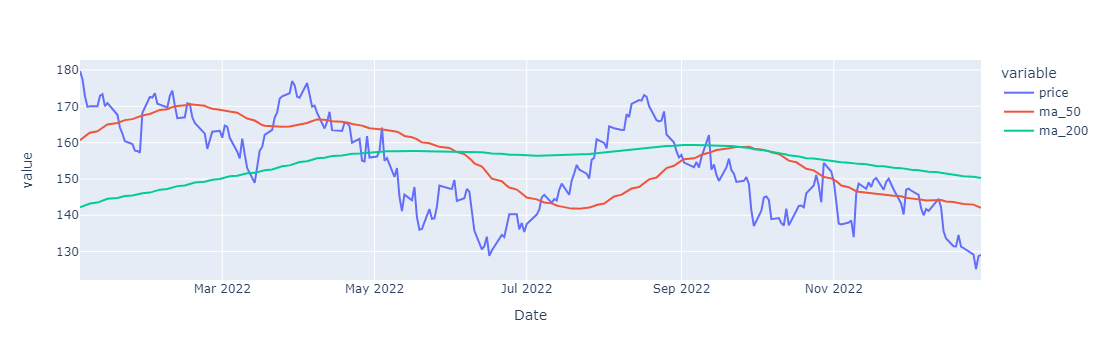

In [77]:
# plot time series
plt.Figure(figsize=(10,25))

fig = px.line(
    data_frame=plot_data, 
    x=plot_data.index, 
    y=['price', 'ma_50', 'ma_200']
)

# Display plot
fig.show()

In [63]:
# Split the data into training and testing sets
cutoff = '2020-08-31'
train_data = df.loc[:cutoff, :]
test_data = df.loc[:cutoff,:]

### Split

In [64]:
import datetime as dt
df['Date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 252 entries, 0 to 251
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
252 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.1 KB


In [68]:
def create_features(df):
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month

    return df

train_features = create_features(train_data.copy())
test_features = create_features(test_data.copy())

In [69]:
# Define the features and the target
feature_columns = ['dayofyear', 'dayofweek', 'month', 'sin1', 'cos1', 'sin2', 'cos2']
target_column = 'Price'

## Build Model

### Iterate

In [70]:
# Model Pipeline
pipeline = Pipeline(steps=[
    ('encoder', ColumnTransformer(
        transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), ['dayofweek', 'month'])],
        remainder='passthrough')),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror'))
])

# Fit the model
pipeline.fit(train_features[feature_columns], train_features[target_column])


Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['dayofweek', 'month'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False,...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### Evaluate

In [71]:
# Predict using the model
train_preds = pipeline.predict(train_features[feature_columns])
test_preds = pipeline.predict(test_features[feature_columns])

In [72]:
# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(train_features[target_column], train_preds))
test_rmse = np.sqrt(mean_squared_error(test_features[target_column], test_preds))
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 0.4368402748569198, Test RMSE: 0.4368402748569198


In [77]:
# Create future dates for forecasting
future_dates = pd.date_range(start=test_data['Date'].max() + timedelta(days=12), periods=180, freq='D')
future_data = pd.DataFrame({'Date': future_dates})
future_features = create_features(future_data.copy())

## Communicate

In [78]:
# Forecast future demand
future_preds = pipeline.predict(future_features[feature_columns])

In [78]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train_data['Date'], train_data['Price'], label='Train Data')
plt.plot(test_data['Date'], test_data['Price'], label='Test Data')
plt.plot(future_dates, future_preds, label='Forecast', color='red')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


NameError: name 'train_data' is not defined

<Figure size 1400x700 with 0 Axes>

## Extract Stocks Data

## Technical Indicators

### Trend Indicators:
 - __Moving Averages__ - helps smooth out price data to form a single flowing line, identifying the direction of the trend.

### Add 2 moving averages (20-day and 50-Day)

In [ ]:
sma_df = (
    df[['symbol', 'date', 'adj_close']] 
    .groupby('symbol') 
    .augment_rolling(
        date_column = 'date',
        value_column = 'adj_close',
        window = [20, 50],
        window_func = ['mean'],
        center = False
    )
)

sma_df.head()

,symbol,date,adj_close,adj_close_rolling_mean_win_20,adj_close_rolling_mean_win_50
0,AAPL,2023-01-03,124.216301,NaN,NaN
1,AAPL,2023-01-04,125.497498,NaN,NaN
2,AAPL,2023-01-05,124.166649,NaN,NaN
3,AAPL,2023-01-06,128.735245,NaN,NaN
4,AAPL,2023-01-09,129.261612,NaN,NaN


## Returns Analysis

In finance, returns analysis is like checking how well an investment did compared to how much money was put into it. It helps investors see how their investments are doing and decide if they're worth the risk:

- __Performance:__ Returns analysis tells us how well investments are doing and how much risk they carry.
- __Data-driven Decision Making:__ It helps investors and managers make smart choices about where to put their money, how to manage risk, and what investment strategies to follow.

In [ ]:
# Compute returns per each stock
returns_wide_df = (
    df[['symbol', 'date', 'adj_close']]
    .pivot(index = 'date', columns = 'symbol', values = 'adj_close')
    .pct_change()
    .reset_index()[1:]
)

returns_wide_df

symbol,date,AAPL,GOOGL,MSFT,TSLA
1,2023-01-04,0.010314,-0.011670,-0.043743,0.051249
2,2023-01-05,-0.010605,-0.021344,-0.029638,-0.029039
3,2023-01-06,0.036794,0.013225,0.011785,0.024651
4,2023-01-09,0.004089,0.007786,0.009736,0.059349
5,2023-01-10,0.004456,0.004544,0.007617,-0.007681
...,...,...,...,...,...
245,2023-12-22,-0.005547,0.007620,0.002784,-0.007701
246,2023-12-26,-0.002841,0.000212,0.000214,0.016116
247,2023-12-27,0.000518,-0.008126,-0.001575,0.018822
248,2023-12-28,0.002226,-0.000997,0.003235,-0.031594


In [ ]:
# Descriptive Statistics
returns_wide_df.describe(include='number')

symbol,AAPL,GOOGL,MSFT,TSLA
count,249.000000,249.000000,249.000000,249.000000
mean,0.001835,0.001990,0.001972,0.003893
std,0.012570,0.019149,0.015824,0.033166
min,-0.048020,-0.095094,-0.043743,-0.097458
25%,-0.005891,-0.008987,-0.007579,-0.015368
50%,0.001879,0.001006,0.001672,0.003663
75%,0.008846,0.012367,0.011219,0.021004
max,0.046927,0.072787,0.072435,0.110002


In [ ]:
# Correlation
corr_df = (
    returns_wide_df
    .drop('date', axis=1)
    .corr()
)
corr_df

symbol,AAPL,GOOGL,MSFT,TSLA
symbol,,,,
AAPL,1.000000,0.528273,0.547988,0.444279
GOOGL,0.528273,1.000000,0.509887,0.337729
MSFT,0.547988,0.509887,1.000000,0.317910
TSLA,0.444279,0.337729,0.317910,1.000000


## 50-Day Rolling Regression
We need to make a regression function that returns the Slope and Intercept. 

### Get Market Returns
For our purposes, we assume the market is the average returns of the 6 technology stocks.
- We calculate an equal-weight portfolio as the `market returns`.
- Then we merge the market returns into the returns long data.

## Project: Stock Price Prediction

___Hands-on Project:___ Building a Stock Price Prediction Model using Time Series Analysis Techniques
- Data Collection and Preprocessing
- Model Building and Evaluation
- Fine-tuning Model Parameters for Improved Performance
- Presenting and Interpreting Results